# NOTEBOOK 03 : FEATURE ENGINEERING
**Projet** : REG09 - Prévision des ventes (item_nbr)

**Objectif** : Créer features temporelles (lags, rolling) sur échantillon

**Données** : Réutilisation échantillon HYBRID (20% stores × 365 jours)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
import os
import joblib
from glob import glob

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

## 1. CHARGEMENT DES DONNÉES

In [2]:
# Charger échantillon sauvegardé par notebook 02
# Chercher le fichier le plus récent
sample_files = glob('data/samples/train_sample_hybrid_20pct_365d_*.csv')

if sample_files:
    # Utiliser le plus récent
    sample_file = sorted(sample_files)[-1]
    print(f"Chargement de l'échantillon: {sample_file}")
    train = pd.read_csv(sample_file, parse_dates=['date'])
else:
    # Créer échantillon si pas trouvé
    print("Échantillon non trouvé, création...")
    from data_sampler import SalesDataSampler, optimize_dtypes
    
    items = pd.read_csv('data/items.csv')
    train_full = pd.read_csv('data/train.csv', parse_dates=['date'])
    sampler = SalesDataSampler(train_full, items)
    train = sampler.hybrid_sample(store_frac=0.2, recent_days=365, random_state=42)
    train = optimize_dtypes(train)
    sampler.save_sample(train, 'hybrid_20pct_365d')
    del train_full, sampler

print(f"\nShape: {train.shape}")
print(f"Mémoire: {train.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"Période: {train['date'].min()} à {train['date'].max()}")

Chargement de l'échantillon: data/samples/train_sample_hybrid_20pct_365d_20260214_233500.csv

Shape: (6980883, 6)
Mémoire: 273.0 MB
Période: 2016-08-15 00:00:00 à 2017-08-15 00:00:00


In [3]:
# Charger fichiers auxiliaires
items = pd.read_csv('data/items.csv')
stores = pd.read_csv('data/stores.csv')
oil = pd.read_csv('data/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('data/transactions.csv', parse_dates=['date'])

print("Fichiers auxiliaires chargés")

Fichiers auxiliaires chargés


## 2. PREPROCESSING INITIAL

In [4]:
# Gestion NaN onpromotion
nan_count = train['onpromotion'].isnull().sum()
print(f"NaN dans onpromotion: {nan_count:,} ({nan_count/len(train)*100:.2f}%)")
train['onpromotion'] = train['onpromotion'].fillna(0).astype(int)
print("Remplis avec 0")

NaN dans onpromotion: 0 (0.00%)
Remplis avec 0


In [5]:
# Features pour ventes négatives (retours)
n_neg = (train['unit_sales'] < 0).sum()
print(f"Ventes négatives (retours): {n_neg:,} ({n_neg/len(train)*100:.2f}%)")

train['is_return'] = (train['unit_sales'] < 0).astype(int)
train['unit_sales_abs'] = train['unit_sales'].abs()
print("Features créées: is_return, unit_sales_abs")

Ventes négatives (retours): 435 (0.01%)
Features créées: is_return, unit_sales_abs


## 3. MERGE AVEC DONNÉES AUXILIAIRES

In [6]:
# Merge items
train = train.merge(items[['item_nbr', 'family', 'class', 'perishable']], on='item_nbr', how='left')

# Merge stores
train = train.merge(stores, on='store_nbr', how='left')

# Merge oil (interpoler NaN)
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
train = train.merge(oil, on='date', how='left')

# Merge holidays
holidays_simple = holidays.groupby('date').agg({'type': 'first'}).reset_index()
holidays_simple['is_holiday'] = 1
train = train.merge(holidays_simple[['date', 'is_holiday']], on='date', how='left')
train['is_holiday'] = train['is_holiday'].fillna(0).astype(int)

# Merge transactions
transactions_agg = transactions.groupby(['date', 'store_nbr'])['transactions'].sum().reset_index()
train = train.merge(transactions_agg, on=['date', 'store_nbr'], how='left')
train['transactions'] = train.groupby('store_nbr')['transactions'].transform(
    lambda x: x.fillna(method='ffill').fillna(method='bfill')
)

print(f"Shape après merges: {train.shape}")

Shape après merges: (6980883, 18)


## 4. FEATURES TEMPORELLES

In [7]:
# Features basiques
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek
train['dayofyear'] = train['date'].dt.dayofyear
train['weekofyear'] = train['date'].dt.isocalendar().week.astype(int)
train['quarter'] = train['date'].dt.quarter

# Features cycliques (pour capturer saisonnalité)
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['dayofweek_sin'] = np.sin(2 * np.pi * train['dayofweek'] / 7)
train['dayofweek_cos'] = np.cos(2 * np.pi * train['dayofweek'] / 7)

# Indicateurs booléens
train['is_weekend'] = (train['dayofweek'] >= 5).astype(int)
train['is_month_start'] = train['date'].dt.is_month_start.astype(int)
train['is_month_end'] = train['date'].dt.is_month_end.astype(int)
train['is_payday'] = ((train['day'] == 15) | (train['is_month_end'] == 1)).astype(int)

print("Features temporelles créées")

Features temporelles créées


## 5. FEATURES LAG (7 et 14 jours)

In [8]:
# Trier pour garantir ordre temporel
train = train.sort_values(['store_nbr', 'item_nbr', 'date']).reset_index(drop=True)

print("Création features LAG (7 et 14 jours)...")
print("Attention: peut prendre quelques minutes")

# LAG 7 jours
train['sales_lag_7'] = train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)

# LAG 14 jours
train['sales_lag_14'] = train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(14)

print("Features LAG créées")
print(f"NaN introduits (normal pour début série): {train['sales_lag_7'].isnull().sum():,}")

Création features LAG (7 et 14 jours)...
Attention: peut prendre quelques minutes
Features LAG créées
NaN introduits (normal pour début série): 213,364


## 6. ROLLING STATISTICS (moyenne mobile 7 jours)

In [9]:
print("Création ROLLING MEAN (7 jours)...")

# Rolling mean 7 jours (shift pour éviter data leakage)
train['sales_rolling_mean_7'] = train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
)

print("Rolling features créées")

Création ROLLING MEAN (7 jours)...
Rolling features créées


## 7. ENCODAGE VARIABLES CATÉGORIELLES

In [10]:
# Label encoding
cat_cols = ['city', 'state', 'type', 'family', 'class']
cat_cols = [c for c in cat_cols if c in train.columns]

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    train[f'{col}_encoded'] = le.fit_transform(train[col].fillna('Unknown'))
    label_encoders[col] = le

print(f"Label encoding: {len(cat_cols)} colonnes")

# Frequency encoding
freq_cols = ['store_nbr', 'item_nbr']
for col in freq_cols:
    freq_map = train[col].value_counts(normalize=True).to_dict()
    train[f'{col}_freq'] = train[col].map(freq_map)

print(f"Frequency encoding: {len(freq_cols)} colonnes")

Label encoding: 5 colonnes
Frequency encoding: 2 colonnes


## 8. GESTION VALEURS MANQUANTES

In [11]:
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print(f"Colonnes avec NaN: {len(missing)}")
if len(missing) > 0:
    print(f"\nTop 10:\n{missing.head(10)}")
    
    # Remplir NaN numériques avec médiane
    for col in missing.index:
        if train[col].dtype in ['int64', 'float64']:
            median_val = train[col].median()
            train[col].fillna(median_val, inplace=True)
            print(f"  {col}: remplacé par médiane ({median_val:.2f})")
else:
    print("Aucune valeur manquante")

Colonnes avec NaN: 4

Top 10:
dcoilwtico              2099778
sales_lag_14             423998
sales_lag_7              213364
sales_rolling_mean_7      30757
dtype: int64
  dcoilwtico: remplacé par médiane (48.86)
  sales_lag_14: remplacé par médiane (4.00)
  sales_lag_7: remplacé par médiane (4.00)
  sales_rolling_mean_7: remplacé par médiane (4.12)


## 9. SÉLECTION FEATURES FINALES

In [12]:
# Liste des features pour modélisation
feature_cols = [
    # Identifiants
    'store_nbr', 'item_nbr', 'onpromotion',
    
    # Temporelles
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter',
    'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos',
    'is_weekend', 'is_month_start', 'is_month_end', 'is_payday',
    
    # Externes
    'dcoilwtico', 'is_holiday', 'transactions',
    
    # Encodées
    'store_nbr_freq', 'item_nbr_freq',
    'city_encoded', 'state_encoded', 'type_encoded', 'family_encoded', 'class_encoded',
    
    # Lag et Rolling
    'sales_lag_7', 'sales_lag_14', 'sales_rolling_mean_7',
    
    # Dérivées
    'is_return', 'unit_sales_abs', 'perishable', 'cluster'
]

# Filtrer colonnes existantes
feature_cols = [c for c in feature_cols if c in train.columns]

print(f"Nombre de features: {len(feature_cols)}")
print(f"\nListe des features:\n{feature_cols}")

Nombre de features: 35

Liste des features:
['store_nbr', 'item_nbr', 'onpromotion', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'is_weekend', 'is_month_start', 'is_month_end', 'is_payday', 'dcoilwtico', 'is_holiday', 'transactions', 'store_nbr_freq', 'item_nbr_freq', 'city_encoded', 'state_encoded', 'type_encoded', 'family_encoded', 'class_encoded', 'sales_lag_7', 'sales_lag_14', 'sales_rolling_mean_7', 'is_return', 'unit_sales_abs', 'perishable', 'cluster']


In [13]:
# Créer X et y
X = train[feature_cols].copy()
y = train['unit_sales'].copy()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nMémoire X: {X.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

X shape: (6980883, 35)
y shape: (6980883,)

Mémoire X: 1704.3 MB


## 10. ANALYSE IMPORTANCE FEATURES

TOP 15 FEATURES (corrélation avec unit_sales)
unit_sales_abs          0.992822
sales_rolling_mean_7    0.721891
sales_lag_7             0.583441
sales_lag_14            0.552046
transactions            0.142868
store_nbr_freq          0.119708
onpromotion             0.080248
perishable              0.073223
family_encoded          0.050326
item_nbr_freq           0.048793
is_weekend              0.037034
state_encoded           0.032531
dayofweek               0.028445
cluster                 0.022361
city_encoded            0.022190
dtype: float64


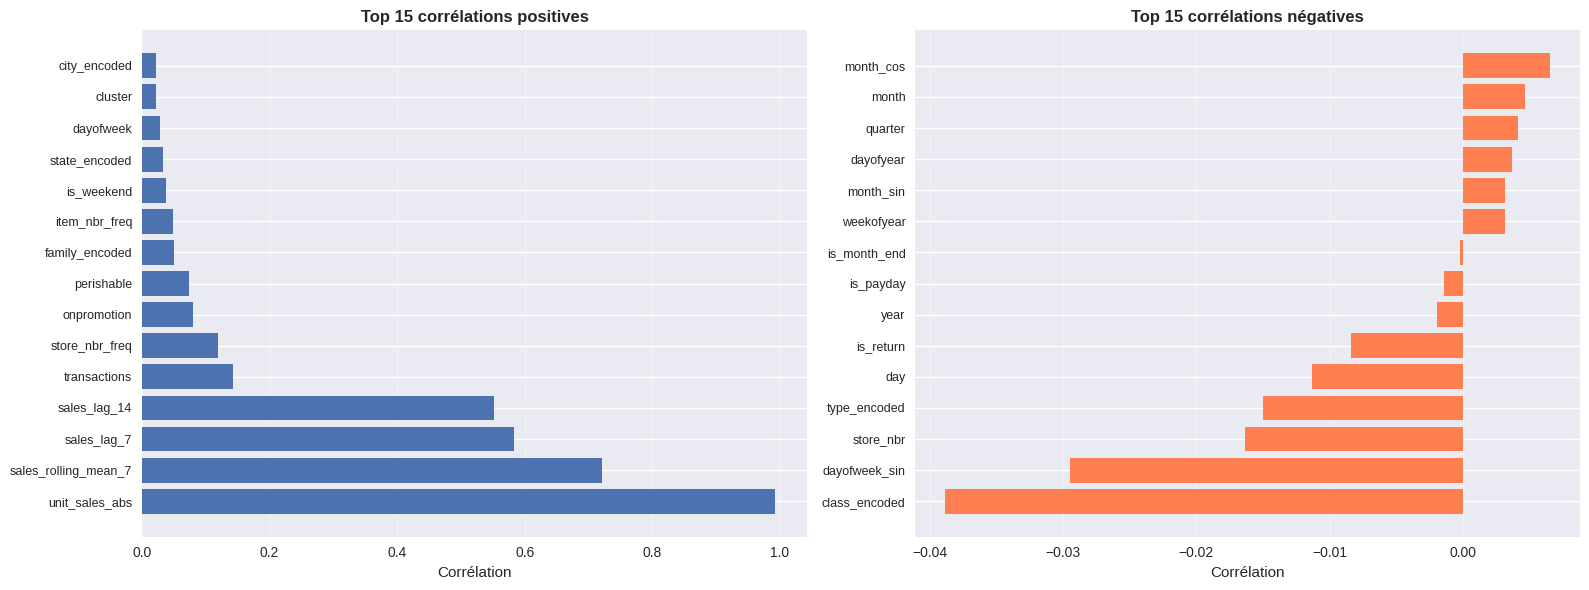

In [14]:
# Corrélations avec cible
correlations = X.corrwith(y).sort_values(ascending=False)

print("=" * 60)
print("TOP 15 FEATURES (corrélation avec unit_sales)")
print("=" * 60)
print(correlations.head(15))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top positives
top15 = correlations.head(15)
axes[0].barh(range(len(top15)), top15.values)
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels(top15.index, fontsize=9)
axes[0].set_title('Top 15 corrélations positives', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Corrélation')
axes[0].grid(alpha=0.3, axis='x')

# Top négatives
bottom15 = correlations.tail(15).sort_values()
axes[1].barh(range(len(bottom15)), bottom15.values, color='coral')
axes[1].set_yticks(range(len(bottom15)))
axes[1].set_yticklabels(bottom15.index, fontsize=9)
axes[1].set_title('Top 15 corrélations négatives', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Corrélation')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('outputs/03_feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. SAUVEGARDE

In [15]:
os.makedirs('data/processed', exist_ok=True)

# Sauvegarder dataset complet avec features
train.to_csv('data/processed/train_with_features.csv', index=False)
print("train_with_features.csv sauvegardé")

# Sauvegarder X et y
X.to_csv('data/processed/X_train.csv', index=False)
y.to_csv('data/processed/y_train.csv', index=False, header=True)
print("X_train.csv et y_train.csv sauvegardés")

# Sauvegarder encoders
joblib.dump(label_encoders, 'data/processed/label_encoders.pkl')
print("label_encoders.pkl sauvegardé")

# Sauvegarder liste features
with open('data/processed/feature_columns.txt', 'w') as f:
    f.write('\n'.join(feature_cols))
print("feature_columns.txt sauvegardé")

print(f"\nFichiers sauvegardés dans data/processed/")

train_with_features.csv sauvegardé
X_train.csv et y_train.csv sauvegardés
label_encoders.pkl sauvegardé
feature_columns.txt sauvegardé

Fichiers sauvegardés dans data/processed/


## 12. SYNTHÈSE

In [16]:
print("=" * 70)
print("SYNTHÈSE FEATURE ENGINEERING")
print("=" * 70)

print("\n1. DONNÉES")
print(f"   Lignes        : {len(train):,}")
print(f"   Période       : {train['date'].min().date()} à {train['date'].max().date()}")
print(f"   Magasins      : {train['store_nbr'].nunique()}")
print(f"   Items         : {train['item_nbr'].nunique()}")

print("\n2. FEATURES CRÉÉES")
print(f"   Temporelles   : 17 (basiques + cycliques + booléens)")
print(f"   Lag           : 2 (7j, 14j)")
print(f"   Rolling       : 1 (moyenne 7j)")
print(f"   Encodées      : {len([c for c in feature_cols if 'encoded' in c or 'freq' in c])}")
print(f"   Dérivées      : 2 (is_return, unit_sales_abs)")
print(f"   Externes      : 3 (oil, holiday, transactions)")
print(f"   TOTAL         : {len(feature_cols)}")

print("\n3. PREPROCESSING")
print(f"   NaN onpromotion : Remplis avec 0")
print(f"   Retours         : Feature is_return créée")
print(f"   Variables cat.  : Label encoding + frequency encoding")
print(f"   NaN features    : Remplis avec médiane")

print("\n4. CORRÉLATIONS TOP 3")
for feat, corr_val in correlations.head(3).items():
    print(f"   {feat:20s} : {corr_val:+.4f}")

print("\n5. FICHIERS SAUVEGARDÉS")
print("   - data/processed/train_with_features.csv")
print("   - data/processed/X_train.csv")
print("   - data/processed/y_train.csv")
print("   - data/processed/label_encoders.pkl")
print("   - data/processed/feature_columns.txt")

print("\n" + "=" * 70)
print("Prêt pour la modélisation (notebook 04)")
print("=" * 70)

SYNTHÈSE FEATURE ENGINEERING

1. DONNÉES
   Lignes        : 6,980,883
   Période       : 2016-08-15 à 2017-08-15
   Magasins      : 10
   Items         : 4016

2. FEATURES CRÉÉES
   Temporelles   : 17 (basiques + cycliques + booléens)
   Lag           : 2 (7j, 14j)
   Rolling       : 1 (moyenne 7j)
   Encodées      : 7
   Dérivées      : 2 (is_return, unit_sales_abs)
   Externes      : 3 (oil, holiday, transactions)
   TOTAL         : 35

3. PREPROCESSING
   NaN onpromotion : Remplis avec 0
   Retours         : Feature is_return créée
   Variables cat.  : Label encoding + frequency encoding
   NaN features    : Remplis avec médiane

4. CORRÉLATIONS TOP 3
   unit_sales_abs       : +0.9928
   sales_rolling_mean_7 : +0.7219
   sales_lag_7          : +0.5834

5. FICHIERS SAUVEGARDÉS
   - data/processed/train_with_features.csv
   - data/processed/X_train.csv
   - data/processed/y_train.csv
   - data/processed/label_encoders.pkl
   - data/processed/feature_columns.txt

Prêt pour la modélisat